In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from astropy.visualization import make_lupton_rgb

from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.surveys.dc2 import split_tensor, unpack_dict
from case_studies.weak_lensing.utils.weighted_avg_ellip import compute_weighted_avg_ellip

with initialize(config_path="../../", version_base = None):
    cfg = compose("config_dc2_redbin3")

In [2]:
dc2 = instantiate(cfg.surveys.dc2)
dc2._load_image_and_bg_files_list()

98

In [3]:
# this cell takes 10-20 seconds
image_index = 1
result_dict = dc2.load_image_and_catalog(image_index)

image = result_dict["inputs"]["image"]
tile_dict = result_dict["tile_dict"]
psf_params = result_dict["inputs"]["psf_params"]

shear1 = tile_dict["shear1_sum"] / (
    tile_dict["shear1_count"]
    + (tile_dict["shear1_count"] == 0) * torch.ones_like(tile_dict["shear1_count"])
)
shear2 = tile_dict["shear2_sum"] / (
    tile_dict["shear2_count"]
    + (tile_dict["shear2_count"] == 0) * torch.ones_like(tile_dict["shear2_count"])
)
convergence = tile_dict["convergence_sum"] / (
    tile_dict["convergence_count"]
    + (tile_dict["convergence_count"] == 0)
    * torch.ones_like(tile_dict["convergence_count"])
)
ellip1_lensed = tile_dict["ellip1_lensed_sum"] / (
    tile_dict["ellip1_lensed_count"]
    + (tile_dict["ellip1_lensed_count"] == 0)
    * torch.ones_like(tile_dict["ellip1_lensed_count"])
)
ellip2_lensed = tile_dict["ellip2_lensed_sum"] / (
    tile_dict["ellip2_lensed_count"]
    + (tile_dict["ellip2_lensed_count"] == 0)
    * torch.ones_like(tile_dict["ellip2_lensed_count"])
)
ellip_lensed = torch.stack((ellip1_lensed.squeeze(-1), ellip2_lensed.squeeze(-1)), dim=-1)
ellip1_lsst = tile_dict["ellip1_lsst_sum"] / (
    tile_dict["ellip1_lsst_count"]
    + (tile_dict["ellip1_lsst_count"] == 0)
    * torch.ones_like(tile_dict["ellip1_lsst_count"])
)
ellip2_lsst = tile_dict["ellip2_lsst_sum"] / (
    tile_dict["ellip2_lsst_count"]
    + (tile_dict["ellip2_lsst_count"] == 0)
    * torch.ones_like(tile_dict["ellip2_lsst_count"])
)
ellip_lsst = torch.stack((ellip1_lsst.squeeze(-1), ellip2_lsst.squeeze(-1)), dim=-1)
redshift = tile_dict["redshift_sum"] / (
    tile_dict["redshift_count"]
    + (tile_dict["redshift_count"] == 0) * torch.ones_like(tile_dict["redshift_count"])
)
ra = tile_dict["ra_sum"] / (
    tile_dict["ra_count"]
    + (tile_dict["ra_count"] == 0) * torch.ones_like(tile_dict["ra_count"])
)
dec = tile_dict["dec_sum"] / (
    tile_dict["dec_count"]
    + (tile_dict["dec_count"] == 0) * torch.ones_like(tile_dict["dec_count"])
)

tile_dict["shear_1"] = shear1
tile_dict["shear_2"] = shear2
tile_dict["convergence"] = convergence
tile_dict["ellip_lensed"] = ellip_lensed
tile_dict["ellip_lsst"] = ellip_lsst
tile_dict["ellip_lsst_wavg"] = compute_weighted_avg_ellip(
    tile_dict, dc2.avg_ellip_kernel_size, dc2.avg_ellip_kernel_sigma
)
tile_dict["redshift"] = redshift
tile_dict["ra"] = ra
tile_dict["dec"] = dec

data_splits = dc2.split_image_and_tile_cat(image, tile_dict, tile_dict.keys(), psf_params)

data_to_cache = unpack_dict(data_splits)

/home/twhit/bliss/bliss/surveys/dc2.py:418: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch.tensor(psf_params_cur_band)


In [4]:
shear1 = data_to_cache[0]['tile_catalog']['shear_1'].squeeze().flip(dims=[0,1])
shear2 = data_to_cache[0]['tile_catalog']['shear_2'].squeeze().flip(dims=[0,1])
convergence = data_to_cache[0]['tile_catalog']['convergence'].squeeze().flip(dims=[0,1])

Redshift bin 0:

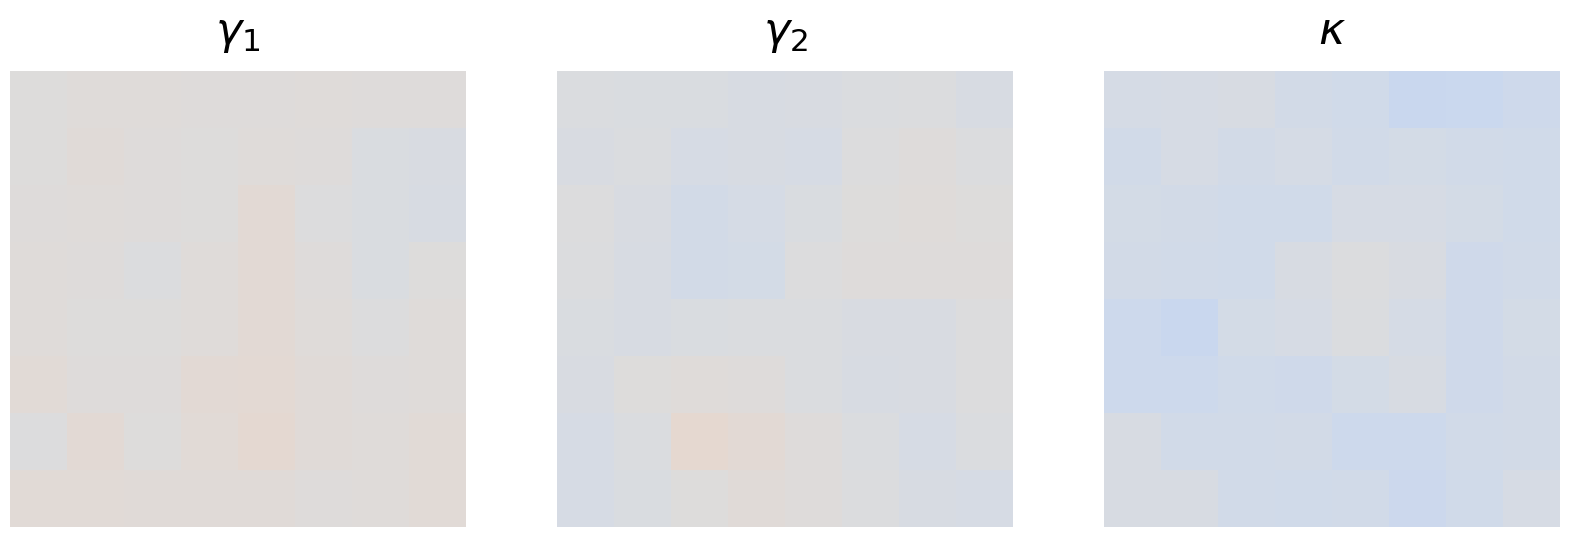

In [11]:
fontsize = 32
cmap = 'coolwarm'
vmin = -0.06
vmax = 0.06

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].imshow(shear1[...,0], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_1$', fontsize=fontsize, pad = 20)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].imshow(shear2[...,0], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[1].set_title(r'$\gamma_2$', fontsize=fontsize, pad = 20)
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].imshow(convergence[...,0], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[2].set_title(r'$\kappa$', fontsize=fontsize, pad = 20)
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2groundtruthmaps_bin0.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 1:

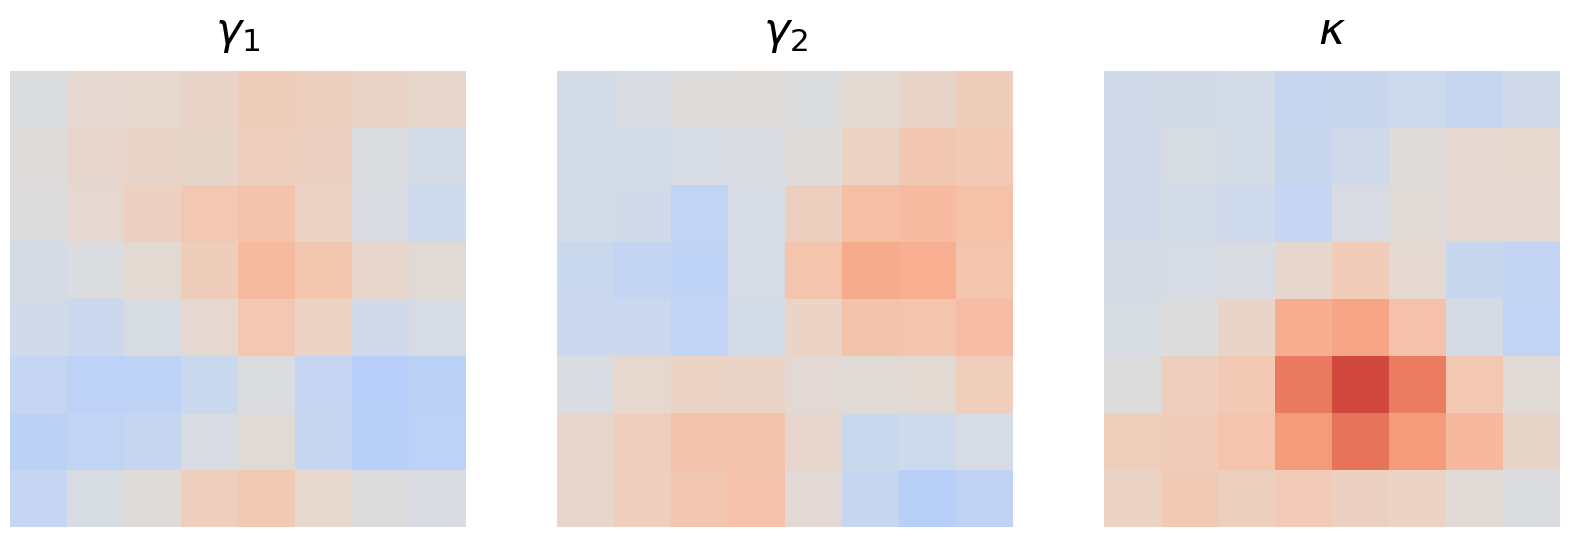

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].imshow(shear1[...,1], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_1$', fontsize=fontsize, pad = 20)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].imshow(shear2[...,1], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[1].set_title(r'$\gamma_2$', fontsize=fontsize, pad = 20)
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].imshow(convergence[...,1], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[2].set_title(r'$\kappa$', fontsize=fontsize, pad = 20)
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2groundtruthmaps_bin1.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 2:

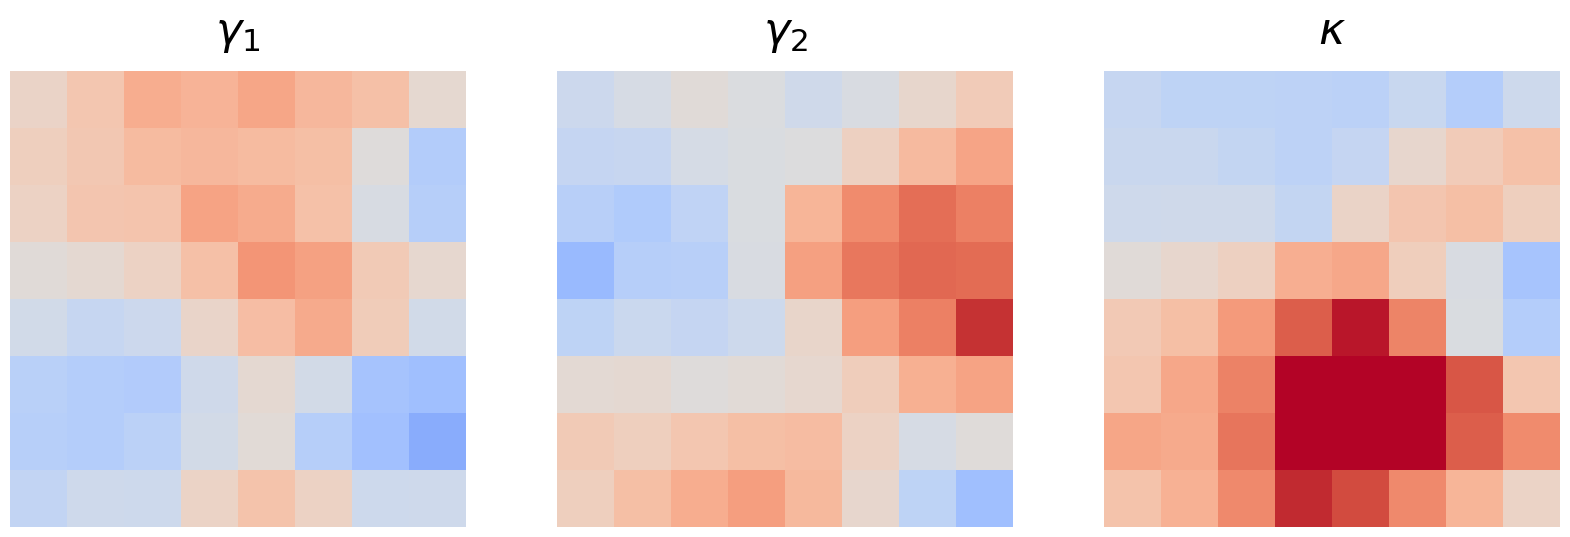

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

_ = ax[0].imshow(shear1[...,2], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[0].set_title(r'$\gamma_1$', fontsize=fontsize, pad = 20)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

_ = ax[1].imshow(shear2[...,2], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[1].set_title(r'$\gamma_2$', fontsize=fontsize, pad = 20)
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])

_ = ax[2].imshow(convergence[...,2], cmap=cmap, vmin=vmin, vmax=vmax)
_ = ax[2].set_title(r'$\kappa$', fontsize=fontsize, pad = 20)
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/dc2groundtruthmaps_bin2.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)